# Predicción de default financiero usando métodos de aprendizaje automático

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

## **Líbrerías y funciones**

In [170]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor


In [171]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=40,ax=ax, facecolor='midnightblue', edgecolor='black')
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        # remove grid lines
        ax.grid(False)

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


In [172]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')

In [173]:
# If you are using kaggle, use this to download dataset in the same folder
import os
os.system('kaggle competitions download -c GiveMeSomeCredit -p ./data')

0

## **Dataset**

In [174]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')
test=pd.read_csv('data/cs-test.csv')
d.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,9120.00,13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,2600.00,4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,3042.00,2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,3300.00,5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,63588.00,7,0,1,0,0.00
5,6,0,0.21,74,0,0.38,3500.00,3,0,1,0,1.00
6,7,0,0.31,57,0,5710.00,NaN,8,0,3,0,0.00
7,8,0,0.75,39,0,0.21,3500.00,8,0,0,0,0.00
8,9,0,0.12,27,0,46.00,NaN,2,0,0,0,NaN
9,10,0,0.19,57,0,0.61,23684.00,9,0,4,0,2.00


### **Renombrando variables**
<br> Estas especificaciones están contenidas en la Tabla 2 del trabajo de monografía.

In [175]:
# renombramiento de variables
def rename_variables(df):
    return df.rename(
        columns={
            "RevolvingUtilizationOfUnsecuredLines": "TasaUtilizacionLineasRotativas",
            "age": "Edad",
            "NumberOfTime30-59DaysPastDueNotWorse": "Mora30a59dias",
            "DebtRatio": "RazonDeudaMensual",
            "MonthlyIncome": "IngresoMensual",
            "NumberOfOpenCreditLinesAndLoans": "CantidadCreditosActivos",
            "NumberOfTimes90DaysLate": "MoraMayorA90",
            "NumberRealEstateLoansOrLines": "CantidadCreditosDeVivienda",
            "NumberOfTime60-89DaysPastDueNotWorse": "Mora60a89dias",
            "NumberOfDependents": "CantidadDependientes",
            "SeriousDlqin2yrs": "Incumplimiento"
        }
    )
d = rename_variables(d)
test = rename_variables(test)

La primera columna de los datos de entrenamiento y validación identificada como `Unnamed: 0` corresponde a un identificador de fila que no aporta valor al modelo, por lo tanto se elimina.

In [176]:
#Borrando columnas que no se emplearán
d.drop(['Unnamed: 0'], axis='columns', inplace=True)

**Dimensiones y tipos de variables**

In [177]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Incumplimiento                  150000 non-null  int64  
 1   TasaUtilizacionLineasRotativas  150000 non-null  float64
 2   Edad                            150000 non-null  int64  
 3   Mora30a59dias                   150000 non-null  int64  
 4   RazonDeudaMensual               150000 non-null  float64
 5   IngresoMensual                  120269 non-null  float64
 6   CantidadCreditosActivos         150000 non-null  int64  
 7   MoraMayorA90                    150000 non-null  int64  
 8   CantidadCreditosDeVivienda      150000 non-null  int64  
 9   Mora60a89dias                   150000 non-null  int64  
 10  CantidadDependientes            146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [178]:
d.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes
count,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


**Histogramas**
<br> La base de datos contiene información de población entre los 20 y 80 años (distribución gausiana) con 0 personas a cargo (dependientes) en su gran mayoría, los cuales adquieren más de 2 créditos de forma simultánea (campana a la izquierda `LineasCredito`)

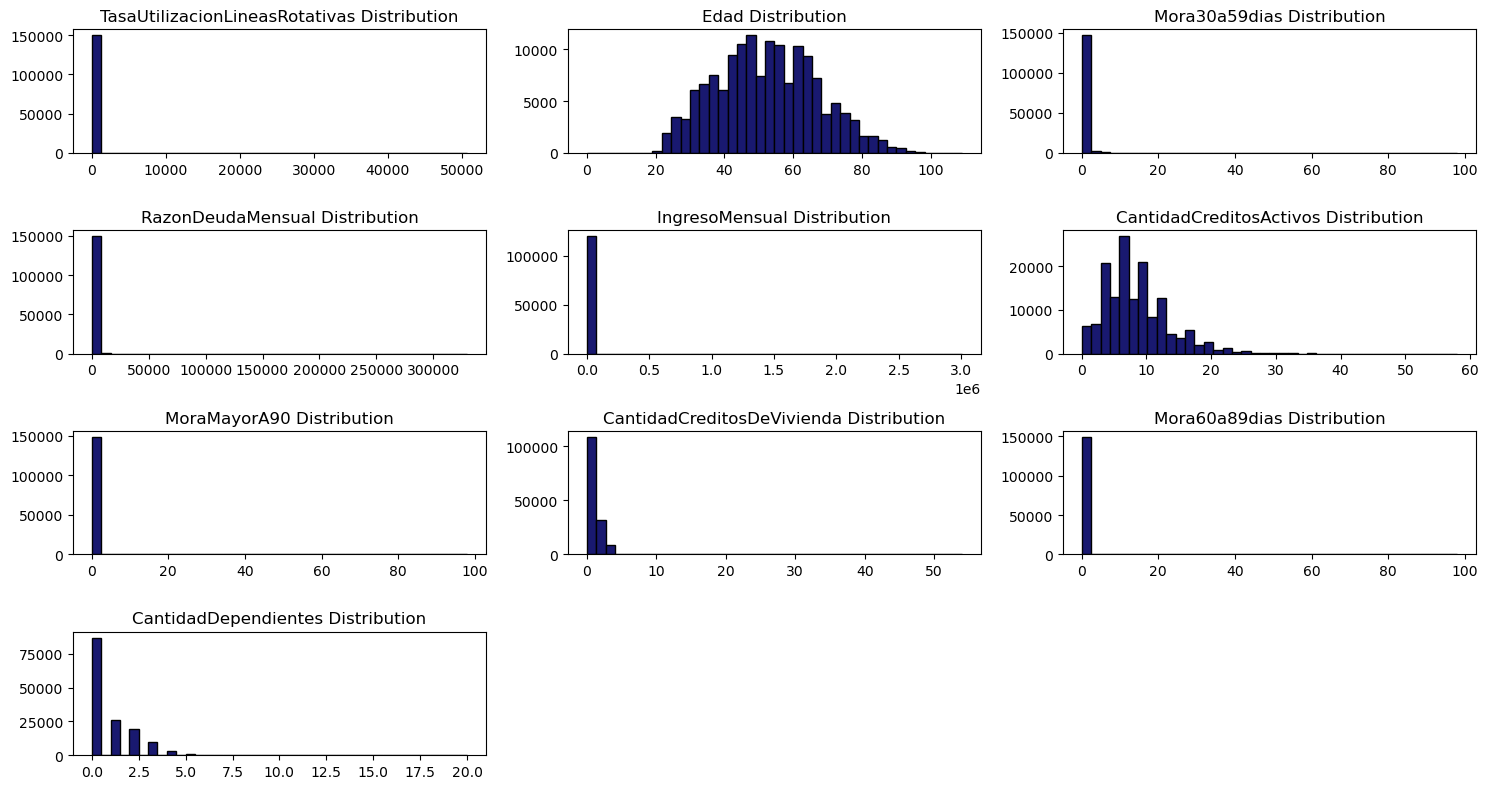

In [179]:
#Lista de variables numéricas
features = d.columns.tolist()
features.remove('Incumplimiento')

# filter d only with numCols columns
draw_histograms(d[features], d[features].columns, 4, 3)

A continuación se realiza un histograma para cada variable del dataset de prueba, con el fin de identificar la distribución de los datos y la presencia de valores atípicos. Esto también sirve para comparar la distribución de los datos de entrenamiento y validación para cada variable.

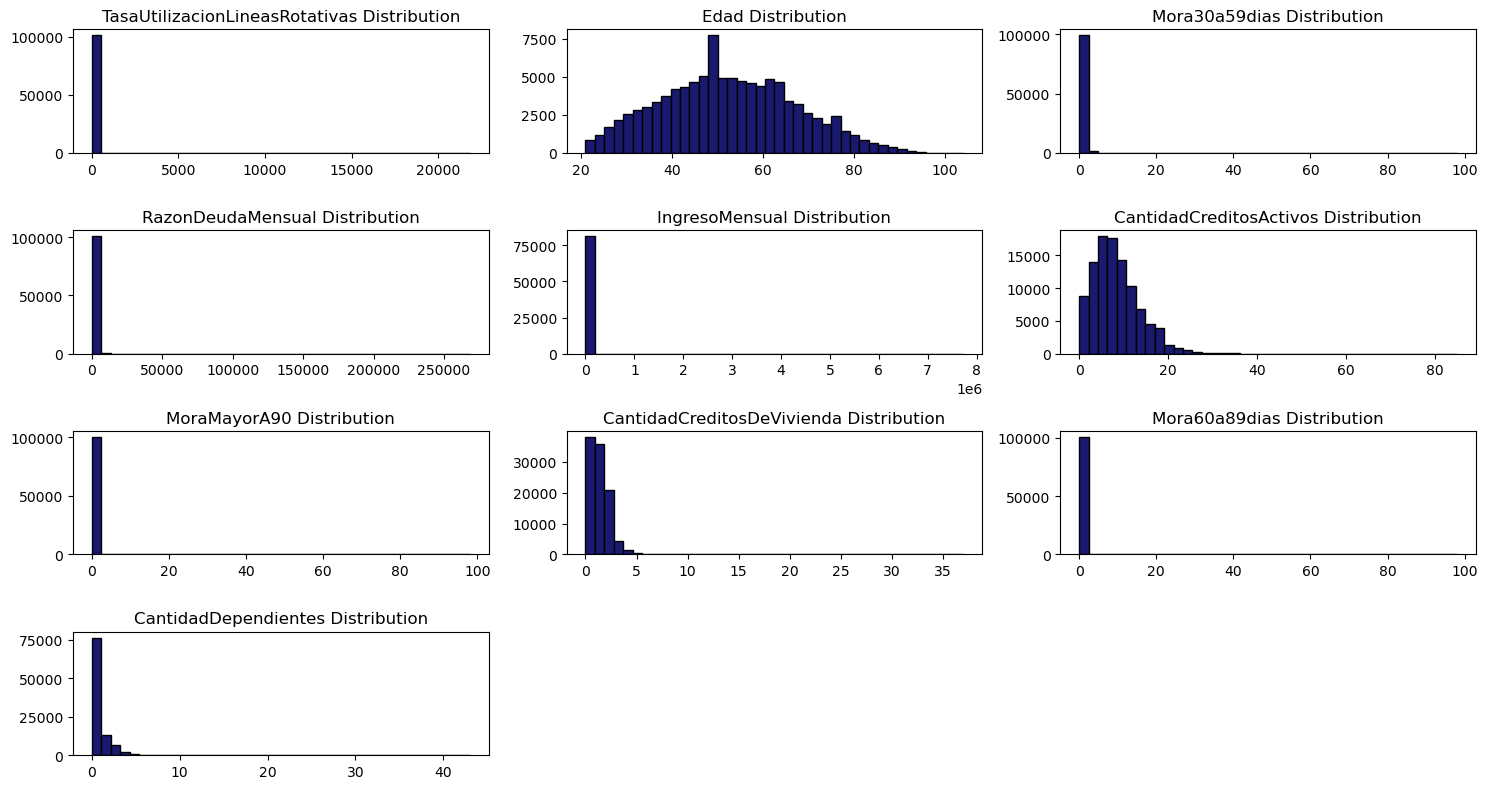

In [180]:
draw_histograms(test[features], test[features].columns, 4, 3)

### **Análisis de la relación lineal entre las variables**

La matriz de correlación permite identificar la relación lineal entre las variables, es decir, si una variable aumenta o disminuye en función de otra. En la diagonal se observa la relación de cada variable consigo misma, la cual es perfecta (1) por definición. En la parte inferior de la matriz se observa la relación entre las variables, por ejemplo, `CantidadCreditosDeVivienda` y `CantidadCreditosActivos` tienen una correlación de 0.43, lo cual indica que a medida que la cantidad de créditos aumenta, el número de créditos activos también lo hace.


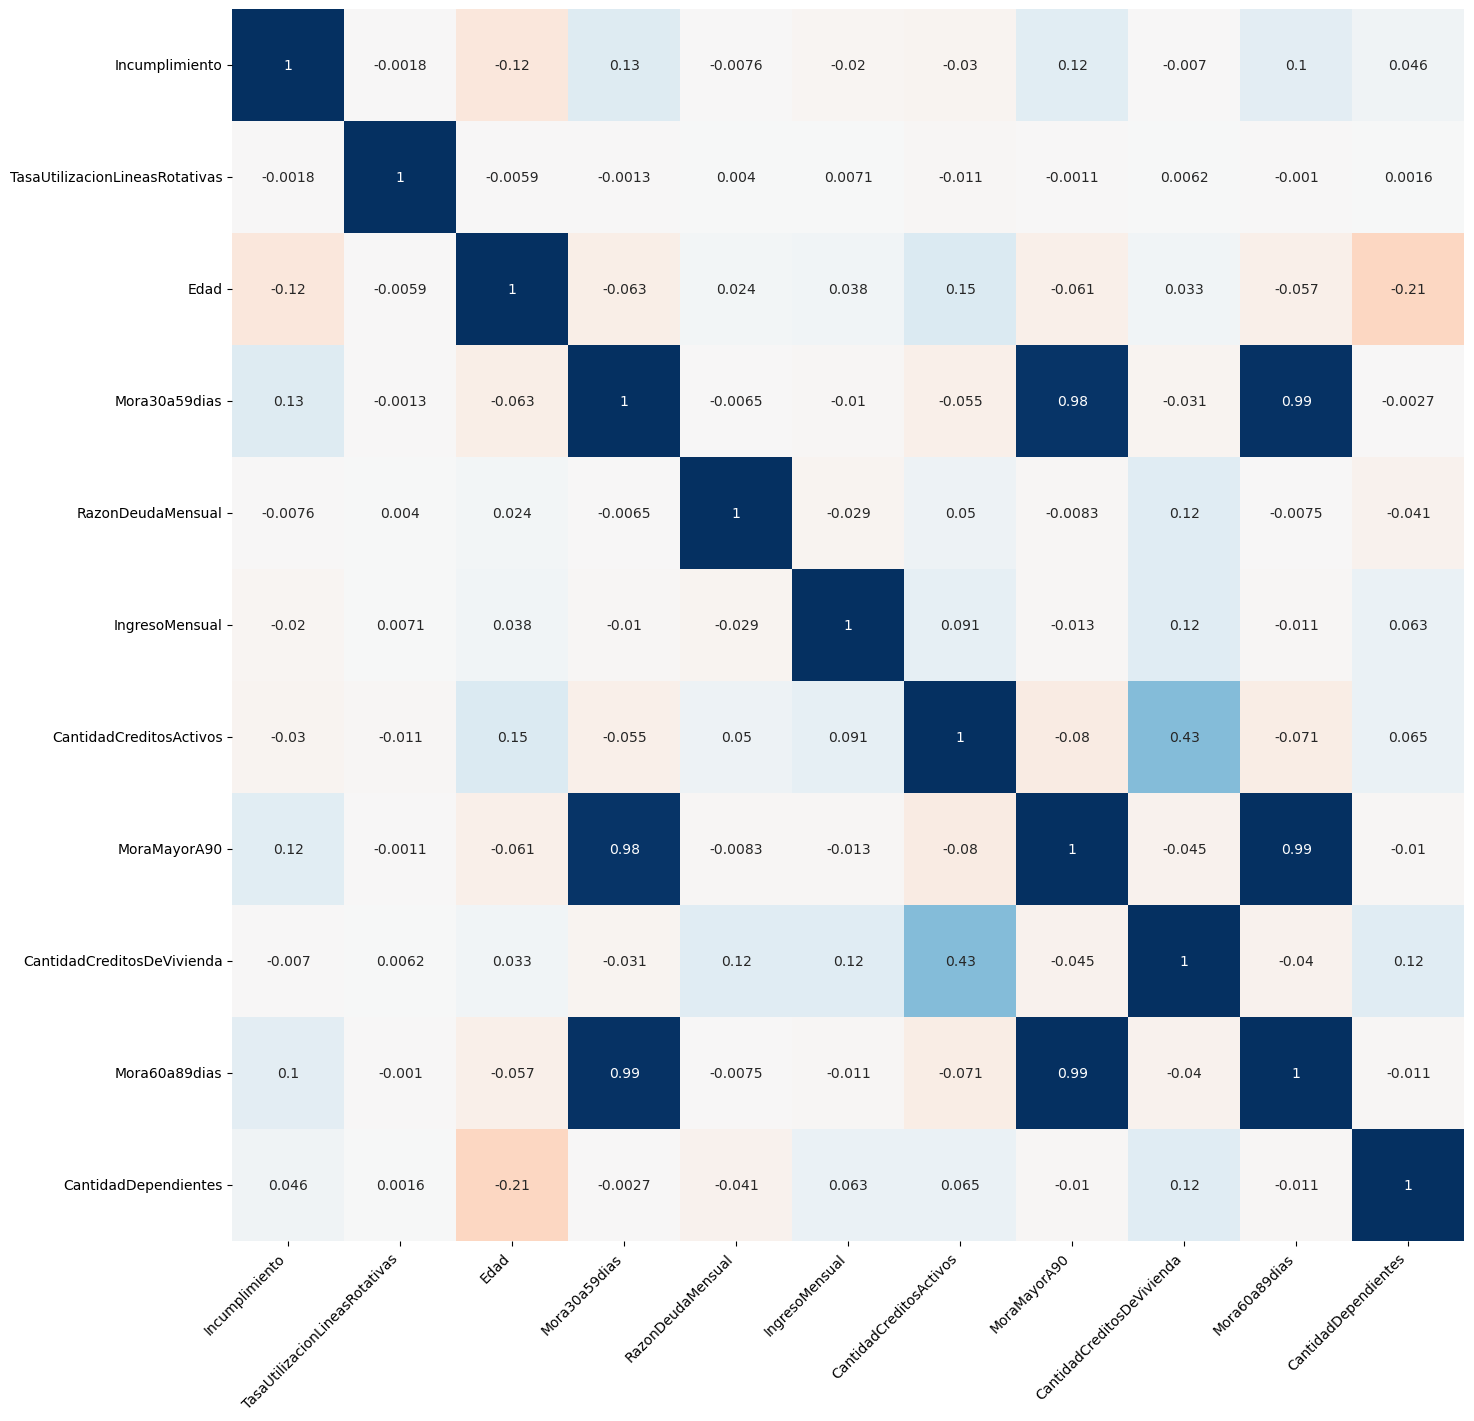

In [181]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

## **Detección de atípicos**

In [182]:
def plot_histograms_variables(var):
    # subplots to graph boxplots of variable TasaUtilizacionLineasRotativas
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    sns.boxplot(
        x = d[var],
        ax   = ax,
        color = 'blue'
    )

    ax.tick_params(labelsize = 10)
    ax.set_xlabel(
        var,
        fontsize = 10,
    )

    fig.tight_layout()

### TasaUtilizacionLineasRotativas

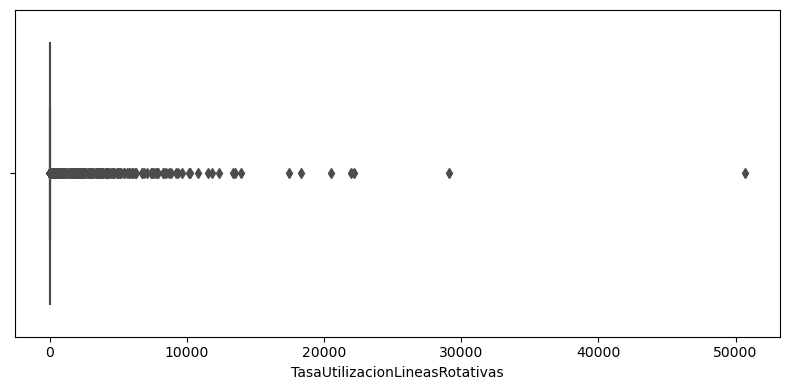

In [183]:
# boxplot de la variable TasaUtilizacionLineasRotativas no using function plot_histograms_variables
plot_histograms_variables('TasaUtilizacionLineasRotativas')

In [184]:
d["TasaUtilizacionLineasRotativas"].describe()

count   150000.00
mean         6.05
std        249.76
min          0.00
25%          0.03
50%          0.15
75%          0.56
max      50708.00
Name: TasaUtilizacionLineasRotativas, dtype: float64

In [185]:
# count of outliers > 1 in variable TasaUtilizacionLineasRotativas
# 3321 - 3321/150000 = 97.8% of data is not outlier
d[d['TasaUtilizacionLineasRotativas']>1].shape[0]
original_size = len(d)
perc_outliers = d[d['TasaUtilizacionLineasRotativas']>1].shape[0]/original_size
# format print percentage with 2 decimals
print(f"Outliers para TasaUtilizacionLineasRotativas: {d[d['TasaUtilizacionLineasRotativas']>1].shape[0]} ({perc_outliers:.2%})")

Outliers para TasaUtilizacionLineasRotativas: 3321 (2.21%)


In [186]:
# remove values of TasaUtilizacionLineasRotativas > 1
d = d[d['TasaUtilizacionLineasRotativas']<=1]

In [187]:
d["TasaUtilizacionLineasRotativas"].describe()

count   146679.00
mean         0.30
std          0.34
min          0.00
25%          0.03
50%          0.14
75%          0.52
max          1.00
Name: TasaUtilizacionLineasRotativas, dtype: float64

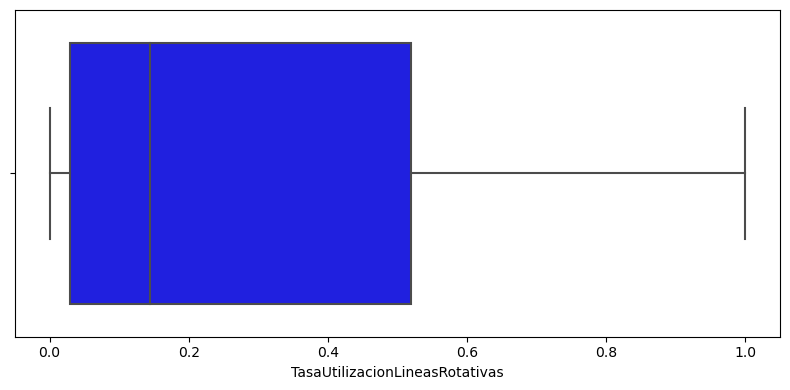

In [188]:
# boxplot de la variable TasaUtilizacionLineasRotativas no using function plot_histograms_variables
plot_histograms_variables('TasaUtilizacionLineasRotativas')

La variable `TasaUtilizacionLineasRotativas` muestra el balance total de las tarjetas de crédito y lineas personales de crédito dividido por los cupos de estos créditos. Esto quiere decir que si una persona tiene $100 de cupo y usa $30, tendrá entonces una Tasa de utilización del 0.3. Se entiende entonces que corresponde a un porcentaje cuyos valores validos son de 0 a 1. 

Se eliminan un total de 3.321 registros detectados como outliers que corresponden al 2.21% de los datos de entrenamiento. 

### Ocurrencias de mora

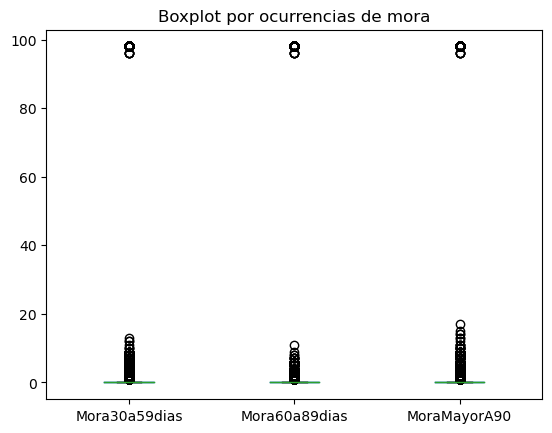

In [189]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

**Análisis de distribución de las variables categóricas para una ventana de dos años (730 días)**. Se definen como valores atípicos para esta ventana de tiempo registros cuyo valor sea superior a:
* 25 ocurrencias de mora en la ventana de 30 a 59 días
* 13 ocurrencias de mora en la ventana de 60 a 89 días

In [190]:
days_in_two_years = 365 * 2
max_possible_mora30_59 = math.ceil(days_in_two_years / 30)
print(f"Maximum value for Mora30a59: {max_possible_mora30_59}")

max_possible_mora60_89 = math.ceil(days_in_two_years / 60)
print(f"Maximum value for Mora60a89: {max_possible_mora60_89}")

outliers_mora3059 = len(d[d['Mora30a59dias'] > max_possible_mora30_59])
outliers_mora6089 = len(d[d['Mora60a89dias'] > max_possible_mora60_89])

print(f"Instances with Mora30a59 > {max_possible_mora30_59}: {outliers_mora3059} ({outliers_mora3059/len(d):.2%})" )
print(f"Instances with Mora60a89 > {max_possible_mora60_89}: {outliers_mora6089} ({outliers_mora6089/len(d):.2%})" )

Maximum value for Mora30a59: 25
Maximum value for Mora60a89: 13
Instances with Mora30a59 > 25: 269 (0.18%)
Instances with Mora60a89 > 13: 269 (0.18%)


Se encuentran entonces 269 valores atípicos para los variables `Mora30a59dias` y `Mora60a89dias`. Estos valores atípicos corresponden al 0.18% de los datos de entrenamiento. Al no ser una cantidad significativa de datos, se decide eliminarlos.

In [191]:
print(f"length of dataset before deleting {len(d)}")
d = d[(d['Mora30a59dias'] <= max_possible_mora30_59) & (d['Mora60a89dias'] <= max_possible_mora60_89)]
print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 146679
length of dataset after deleting 146410


### Edad

<Axes: xlabel='Edad', ylabel='Count'>

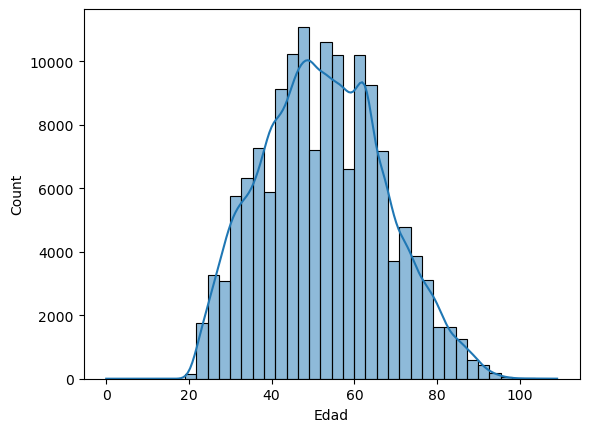

In [192]:
# histogram of variable Edad without using plot_histograms_variables function
sns.histplot(
    d['Edad'],
    bins = 40,
    kde  = True
)


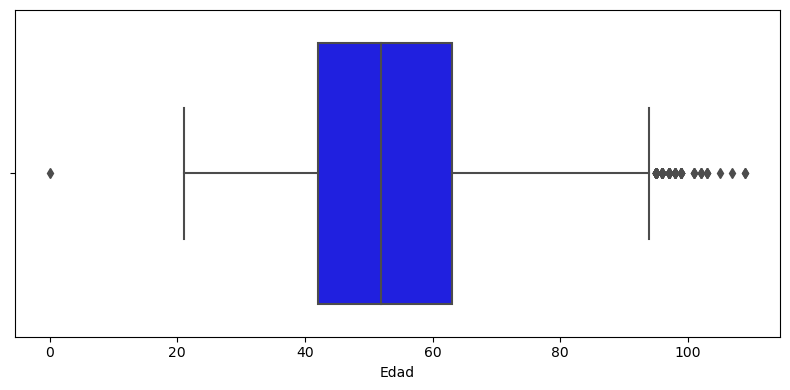

In [193]:
plot_histograms_variables("Edad")

In [194]:
d["Edad"].describe()

count   146410.00
mean        52.52
std         14.75
min          0.00
25%         42.00
50%         52.00
75%         63.00
max        109.00
Name: Edad, dtype: float64

En el caso de la variable `Edad` los valores obtenidos son razonables en general. Se encuentra un único registro con `Edad` igual a cero el cual es eliminado. No es requerido más procesamiento.

In [195]:
d = d[d['Edad'] != 0]


### RazonDeudaMensual

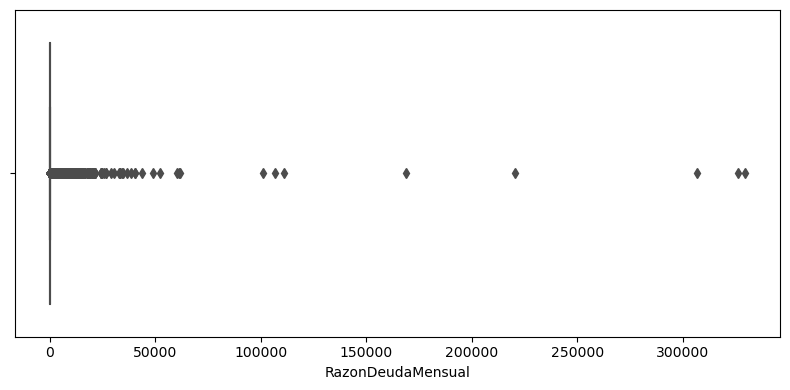

In [196]:
plot_histograms_variables("RazonDeudaMensual")

In [197]:
d["RazonDeudaMensual"].describe()

count   146409.00
mean       356.09
std       2057.68
min          0.00
25%          0.18
50%          0.37
75%          0.87
max     329664.00
Name: RazonDeudaMensual, dtype: float64

In [198]:
# count of outliers > 1 in variable RazonDeudaMensual
d[d['RazonDeudaMensual']>1].shape[0]
original_size = len(d)
thresh = 4000
perc_outliers = d[d['RazonDeudaMensual']>thresh].shape[0]/original_size
# format print percentage with 2 decimals
print(f"Outliers para RazonDeudaMensual: {d[d['RazonDeudaMensual']>thresh].shape[0]} ({perc_outliers:.2%})")

Outliers para RazonDeudaMensual: 2693 (1.84%)


In [199]:
# delete outliers in variable RazonDeudaMensual
print(f"length of dataset before deleting {len(d)}")
d = d[d['RazonDeudaMensual']<=thresh]
print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 146409
length of dataset after deleting 143716


Para la variable `RazonDeudaMensual` se encuentran valores atípicos por encima de 1, que no corresponden con el tipo de dato de esta variable, que es porcentaje. En este caso un valor por encima de 1 (100%) indicaría que las deudas están por encima de los ingresos percibidos mensualmente, lo cual puede ser posible y puede representar una persona con alto riesgo de incumplimiento en el pago de sus obligaciones. Ahora esto puede ser cierto pero dependiendo del rango de los valores que tome esta variable. Si se tiene una razón de deuda mensual de 300.000, que es el máximo valor para el conjunto de entrenamiento; se estaría hablando de unas deudas mensuales equivalentes a 300.000 veces el ingreso mensual, lo cual no sería muy probable en la vida real; en caso de que ocurriese estaríamos nuevamente frente a un caso de una persona con alto riesgo de incumplimiento. 

Estos valores aunque son irreales y pueden deberse a errores en la imputación, se mantienen para el modelo ya que no se puede asegurar que no sean posibles en la vida real. Eliminarlos podría afectar el potencial del modelo. Se escoge un umbral de 4.000 para la eliminación, resultado en una eliminación de 2.693 datos atípicos que corresponden al 1.84% de los datos.

### CantidadDependientes

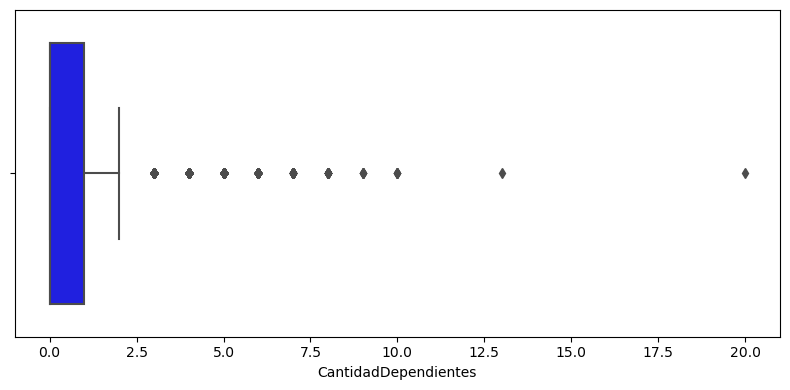

In [200]:
plot_histograms_variables("CantidadDependientes")

In [201]:
d['CantidadDependientes'].describe()

count   140038.00
mean         0.76
std          1.11
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         20.00
Name: CantidadDependientes, dtype: float64

In [202]:
# count nan of CantidadDependientes
print(f"NaN values in CantidadDependientes train: {d['CantidadDependientes'].isna().sum()}")
print(f"NaN values in CantidadDependientes test: {test['CantidadDependientes'].isna().sum()}")

NaN values in CantidadDependientes train: 3678
NaN values in CantidadDependientes test: 2626


In [203]:
# count samples based in threshold value defined for variable CantidadDependientes
thresh = 4
count = len(d[d['CantidadDependientes']>thresh])
print(f"Samples with CantidadDependientes > {thresh} train: {count} ({count/len(d):.2%})")

Samples with CantidadDependientes > 4 train: 949 (0.66%)


In [204]:
print(f"length of dataset before deleting {len(d)}")
d = d[d['CantidadDependientes']<=thresh]
print(f"length of dataset after deleting {len(d)}")

length of dataset before deleting 143716
length of dataset after deleting 139089


In [205]:
d["CantidadDependientes"].fillna(d["CantidadDependientes"].median(), inplace=True)
test["CantidadDependientes"].fillna(d["CantidadDependientes"].median(), inplace=True)

Los valores nulos son imputados con la media de la característica. El número de dependientes tiene algunos valores atípicos que son eliminado, tomo como umbral 4 dependientes, se logra una eliminación de 949 datos atípicos que corresponden al 0.66% de los datos.

### IngresoMensual

In [210]:
def count_outliers(var, df, thresh):
    outliers = df[df[var]>thresh].shape[0]
    # format print percentage with 2 decimals
    print(f"Outliers para {var}: {outliers} ({outliers/len(df):.2%})")

def remove_outliers(var, df, thresh):
    print(f"length of dataset before deleting {len(df)}")
    df = df[df[var]<=thresh]
    print(f"length of dataset after deleting {len(df)}")
    return df

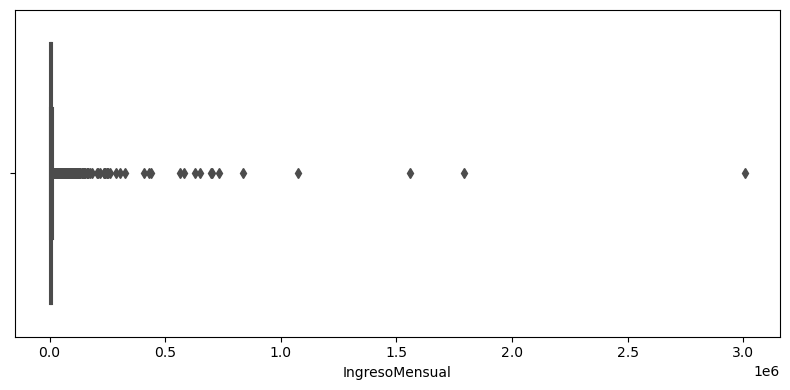

In [206]:
plot_histograms_variables("IngresoMensual")

In [207]:
# count nan values for IngresoMensual
print(f"NaN values in IngresoMensual train: {d['IngresoMensual'].isna().sum()}")

NaN values in IngresoMensual train: 22773


In [208]:
# describe without cientific notation
pd.options.display.float_format = '{:.2f}'.format
d["IngresoMensual"].describe()

count    116316.00
mean       6696.92
std       14582.99
min           0.00
25%        3421.75
50%        5416.00
75%        8283.00
max     3008750.00
Name: IngresoMensual, dtype: float64

In [212]:
d["IngresoMensual"] = d["IngresoMensual"].replace(np.nan, d["IngresoMensual"].median())


In [214]:
count_outliers('IngresoMensual', d, 20000)
#d = remove_outliers('IngresoMensual', d, 20000)

Outliers para IngresoMensual: 2022 (1.45%)


In [217]:
d = remove_outliers('IngresoMensual', d, 20000)

length of dataset before deleting 139089
length of dataset after deleting 137067


El 75% de los datos para la variable `IngresoMensual` en ambos conjuntos de datos se encuentra por debajo de $10.000, lo que es un comportamiento normal. Se encuentran algunos valores atípicos como el máximo de $3.008.750 en el conjunto de entrenamiento, que es un ingreso mensual demasiado elevado y poco probable para el contexto que estamos trabajando; no tendría mucho sentido que una persona con estos ingresos mensuales tenga deudas o necesite créditos. En el conjunto de validación se encuentra un valor maximo de $7.727.000 que también es muy elevado. 
<br> Se encuentran 29.731 datos nulos en el conjunto de entrenamiento y 20.103 en el conjunto de validación. Estos valores nulos son imputados con la media de la característica.
<br> Se define un umbral de 20.000 para la eliminación de valores atípicos, lo que resulta en una eliminación de 2.022 datos atípicos que corresponden al 1.45% de los datos.

### CantidadCreditosDeVivienda

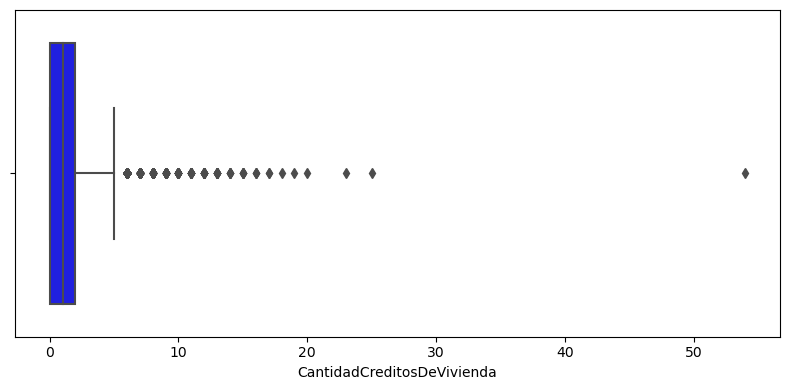

In [218]:
plot_histograms_variables("CantidadCreditosDeVivienda")

In [220]:
d["CantidadCreditosDeVivienda"].describe()

count   137067.00
mean         0.99
std          1.07
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         54.00
Name: CantidadCreditosDeVivienda, dtype: float64

In [229]:
thresh = 20
count_outliers('CantidadCreditosDeVivienda', d, thresh)
d = remove_outliers('CantidadCreditosDeVivienda', d, thresh)

Outliers para CantidadCreditosDeVivienda: 3 (0.00%)
length of dataset before deleting 137067
length of dataset after deleting 137064


Para la variable `CantidadCreditosDeVivienda` , que incluye la cantidad de créditos de hipoteca y lineas de crédito de vivienda, se encuentra que el 75% de los datos están dentro de los rangos esperados para esta variable. Se encuentran datos muy elevados y atípicos como 54 o 37 créditos de vivienda para una persona, lo cual no es muy probable que suceda en la vida real. Es importante resaltar que esta variable habla de la cantidad de créditos y no si los créditos están activos o vigentes, esto quiere decir que se pueda estar contando créditos ya cancelados. 
<br> Para este caso se define un umbral de 20 créditos de vivienda, lo que resulta en una eliminación de 3 datos atípicos que corresponden al 0.00% de los datos.

### CantidadCreditosActivos

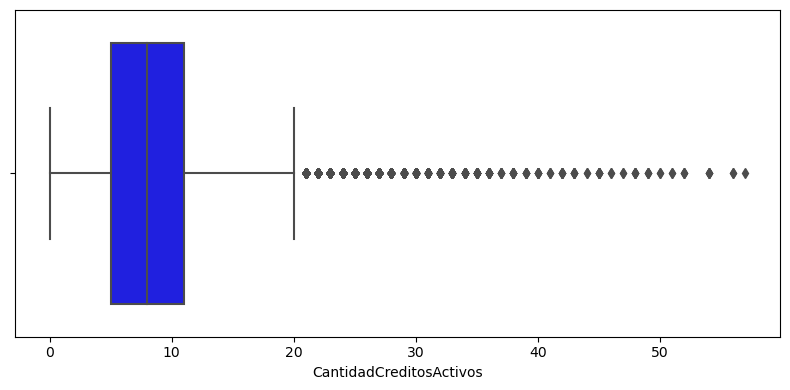

In [230]:
plot_histograms_variables("CantidadCreditosActivos")

In [231]:
d["CantidadCreditosActivos"].describe()

count   137064.00
mean         8.48
std          5.08
min          0.00
25%          5.00
50%          8.00
75%         11.00
max         57.00
Name: CantidadCreditosActivos, dtype: float64

In [233]:
thresh = 50
count_outliers('CantidadCreditosActivos', d, thresh)

Outliers para CantidadCreditosActivos: 12 (0.01%)


En esta variable se encuentran datos que podrían considerarse atípicos, sin embargo, se mantienen dado que pueden suceder en la vida real. Sería normal que una persona tenga 30 o 40 prestamos activos y que esté pagando todos sus créditos de forma normal con los ingresos que percibe. Por esta razón se decide mantener estos datos y no realizar eliminación de atípico para esta variable.

Después de la eliminación de atípicos en el siguiente histograma se describe la nueva distribución de los datos.

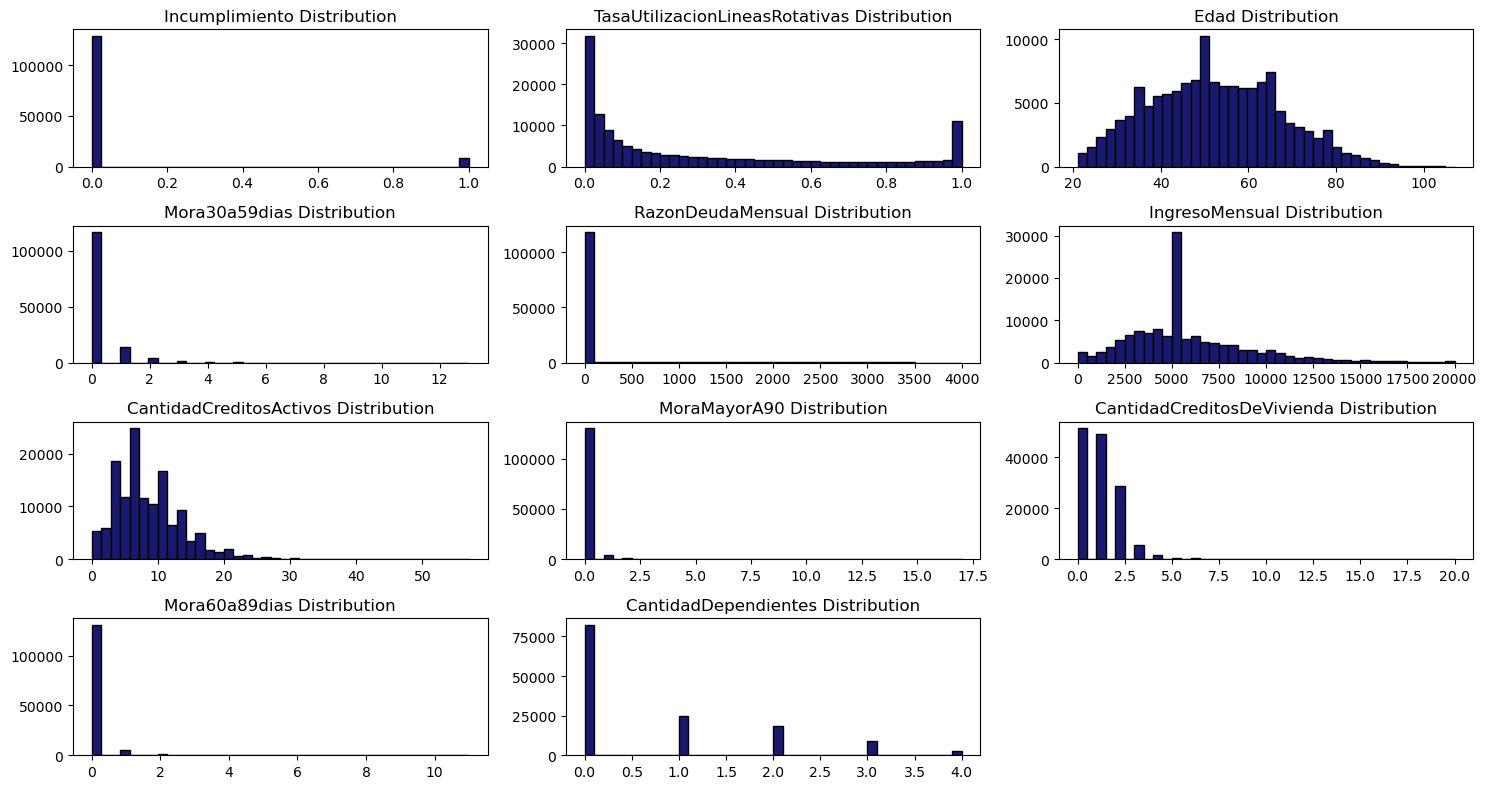

In [235]:
draw_histograms(d, d.columns, 4, 3)

### Conclusiones
- En esta revisión inicial de los datos se encuentra que casí todas las variables presentan datos atípicos. 
- Estos datos atípicos se presentan tanto en el conjunto de entrenamiento como el de validación.
- Sí se eliminan estos datos atípicos se disminuye el conjunto de validación y no se podría subir el reto a kaggle. También se podría perder poder predictivo del modelo.
- Inicialmente se van a mantener estos datos, y esperar los resultados del modelo para tomar decisiones de imputación o eliminación.

Cálculo de la **nueva variable** `OcurrenciasMora`
<br>Esta variable es la suma de las ocurrencias de mora en las ventanas de 30 a 59 días, 60 a 89 días y mayor a 90 días para cada registro.

In [46]:
# calculate new variable with the number of moras
d['OcurrenciasMora'] = d['Mora30a59dias'] + d['Mora60a89dias'] + d['MoraMayorA90']

d['OcurrenciasMora'].describe()

count   149999.00
mean         0.93
std         12.47
min          0.00
25%          0.00
50%          0.00
75%          0.00
max        294.00
Name: OcurrenciasMora, dtype: float64

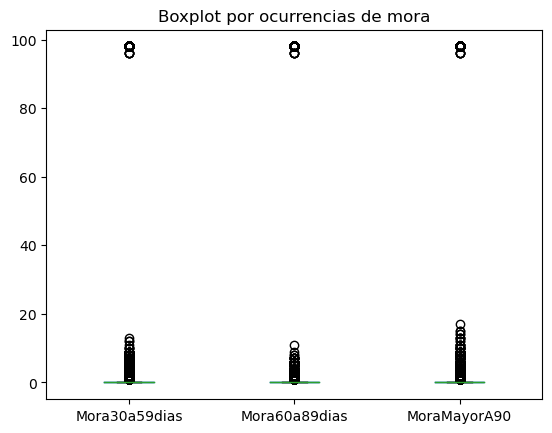

In [47]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

Análisis de la relación lineal **POS eliminación de atípicos ocurrencias por mora**

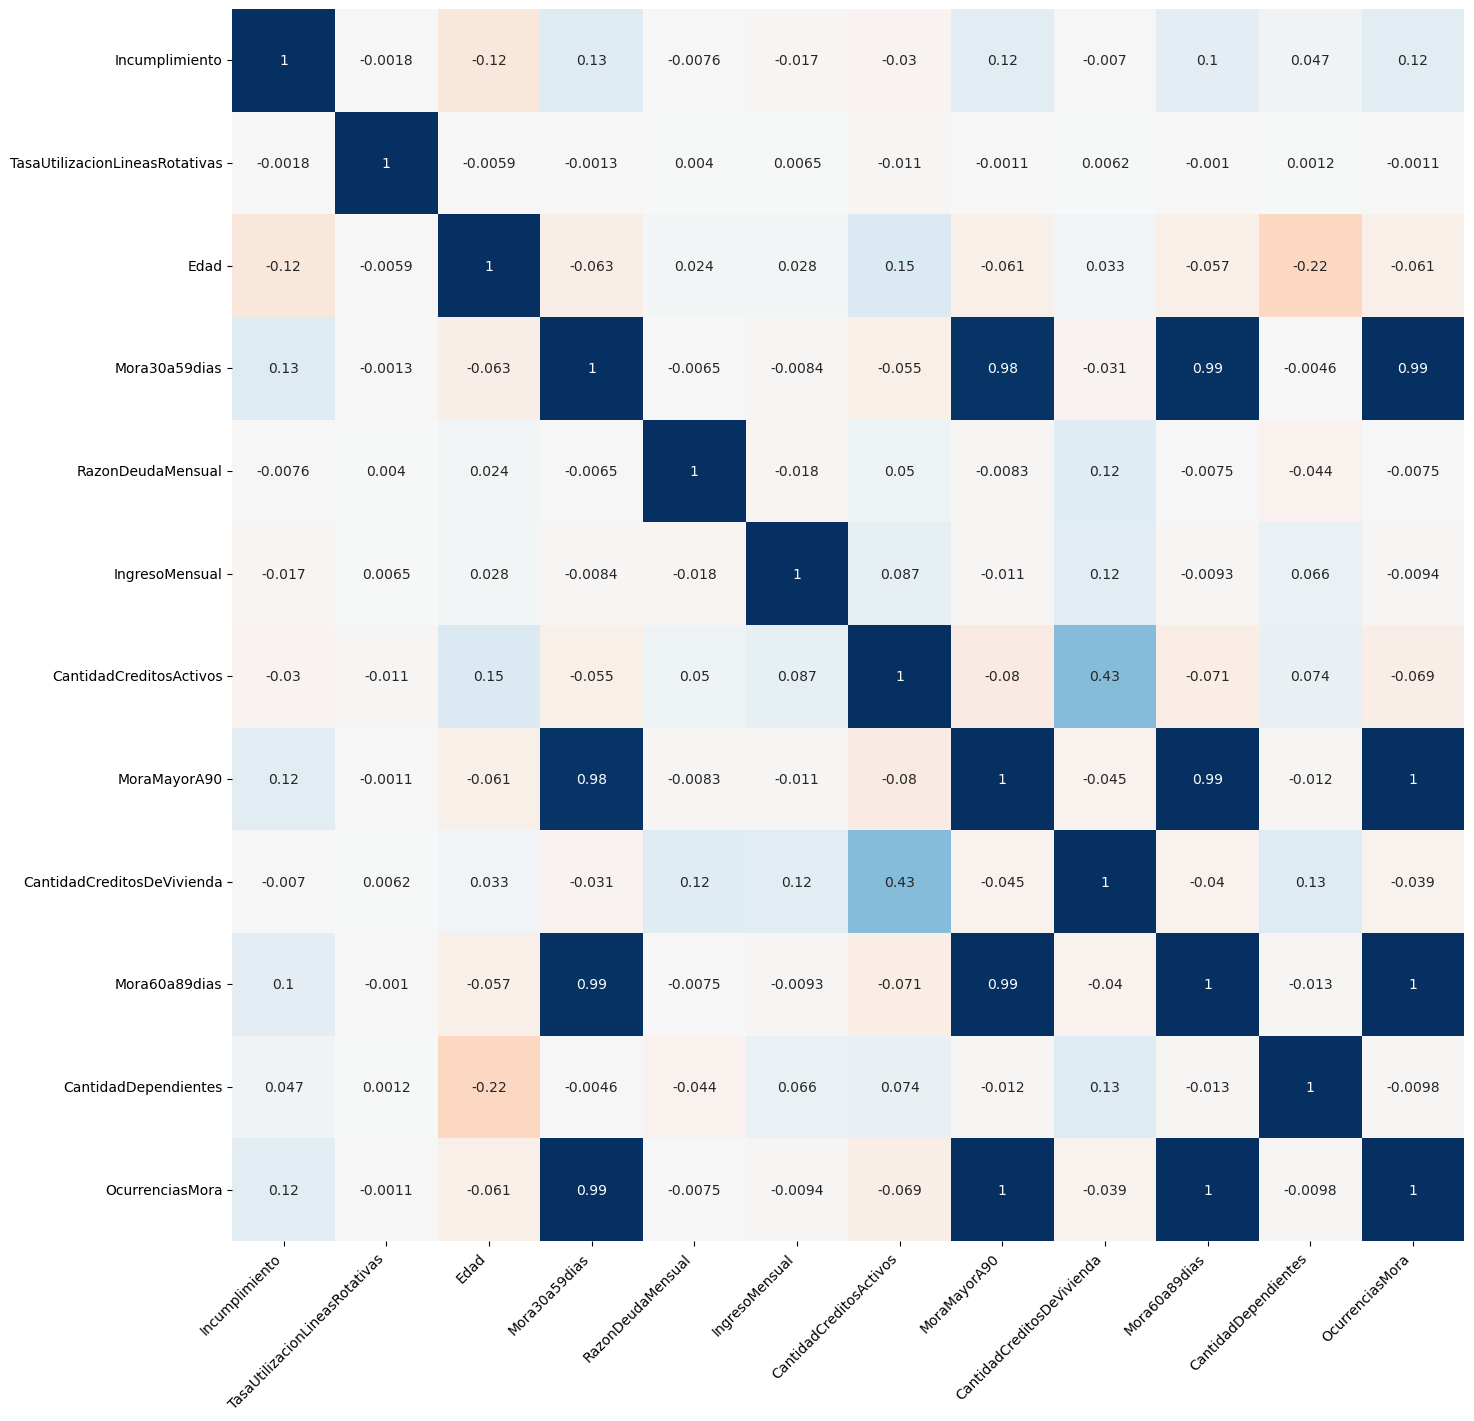

In [48]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Al eliminar los valores atípicos de las variables temporales `Mora30a59dias` y `Mora60a89dias` se puede observar como se redefine la relación lineal entre las variables, pasando de ~0.98 a ~0.20. Sin embargo, se sigue evidenciando que estas variables tienen una correlación más alta en comparación con las demás variables en la base de datos.
<br> También se puede evidenciar que en general las variables analizadas no están directamente correlacionadas con la variable de interés para la clasificación (`Incumplimiento`), se obtienen valores de correlación menores a 0.31 en todos los casos.

### **Atípicos utilizando LOF**

Eliminación de valores atípicos utilizando el método Detección de valores atípicos con Local Outlier Factor [(LOF)](https://qu4nt.github.io/sklearn-doc-es/auto_examples/neighbors/plot_lof_outlier_detection.html). La puntuación de anomalía de cada muestra se denomina Factor de Anomalía Local. Mide la desviación local de la densidad de una muestra dada con respecto a sus vecinos. Es local en el sentido de que el valor de la anomalía depende de lo aislado que esté el objeto con respecto al vecindario circundante. Más concretamente, la localidad viene dada por los k vecinos más cercanos, cuya distancia se utiliza para estimar la densidad local. Comparando la densidad local de una muestra con las densidades locales de sus vecinos, se pueden identificar las muestras que tienen una densidad sustancialmente menor que sus vecinos. Estas se consideran valores atípicos.

In [19]:
# crear un objeto LocalOutlierFactor con n_neighbors=14
lof = LocalOutlierFactor(n_neighbors=2, algorithm='auto', contamination='auto', metric='euclidean')

y_pred = lof.fit_predict(d[features])
ground_truth = np.ones(len(d[features]), dtype=int)
outliers = y_pred != ground_truth
#outliers = y_pred == -1
print(f"Valores atípicos detectados: { (y_pred != ground_truth).sum()}")
#print(f"Valores atípicos detectados: {np.count_nonzero(outliers)}")
#print('Indices de valores atípicos: ', d[outliers].index.tolist())

Valores atípicos detectados: 15100


In [20]:
df = d[~outliers]

In [21]:
print(f"length of dataset before deleting {len(d)}")
print(f"length of dataset after deleting {len(df)}")

length of dataset before deleting 149730
length of dataset after deleting 134630


(0.0, 20.0)

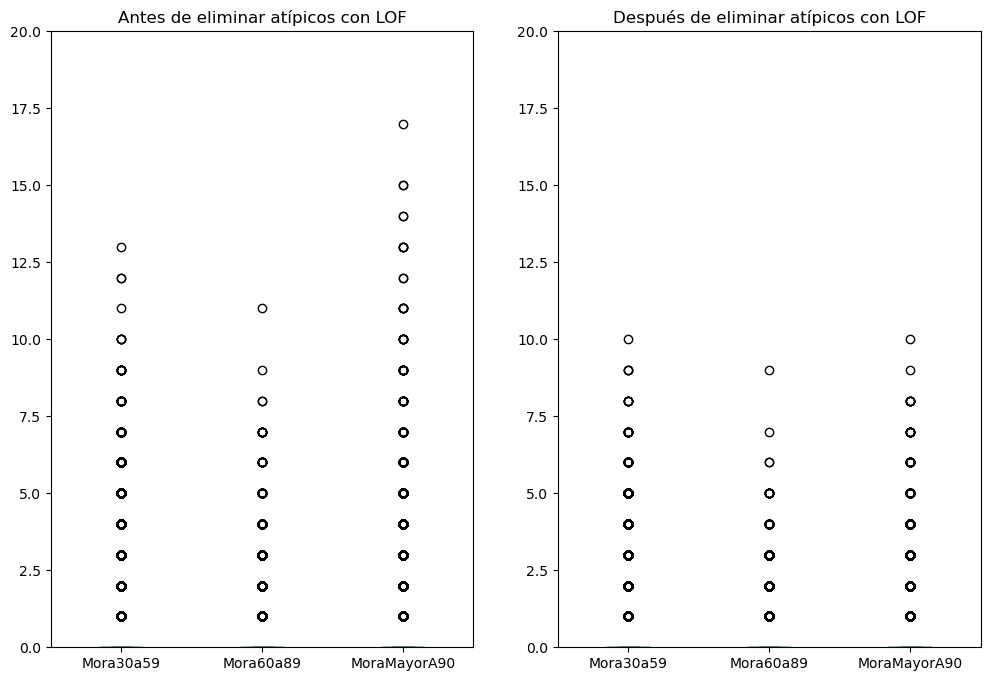

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
sns.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[0],grid=False)  
ax[0].set_title('Antes de eliminar atípicos con LOF')
ax[0].set_ylim(0,20)
sns.boxplot = df.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[1],grid=False)  
ax[1].set_title('Después de eliminar atípicos con LOF')
ax[1].set_ylim(0,20)

Considero que no debemos eliminar atípicos, al menos no en estas variables temporales

Incumplimiento             Axes(0.125,0.11;0.0545775x0.77)
Cupos                   Axes(0.190493,0.11;0.0545775x0.77)
Edad                    Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59               Axes(0.321479,0.11;0.0545775x0.77)
RatioDeuda              Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual          Axes(0.452465,0.11;0.0545775x0.77)
LineasCredito           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90            Axes(0.583451,0.11;0.0545775x0.77)
CreditosHipotecarios    Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89               Axes(0.714437,0.11;0.0545775x0.77)
Dependientes             Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora         Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

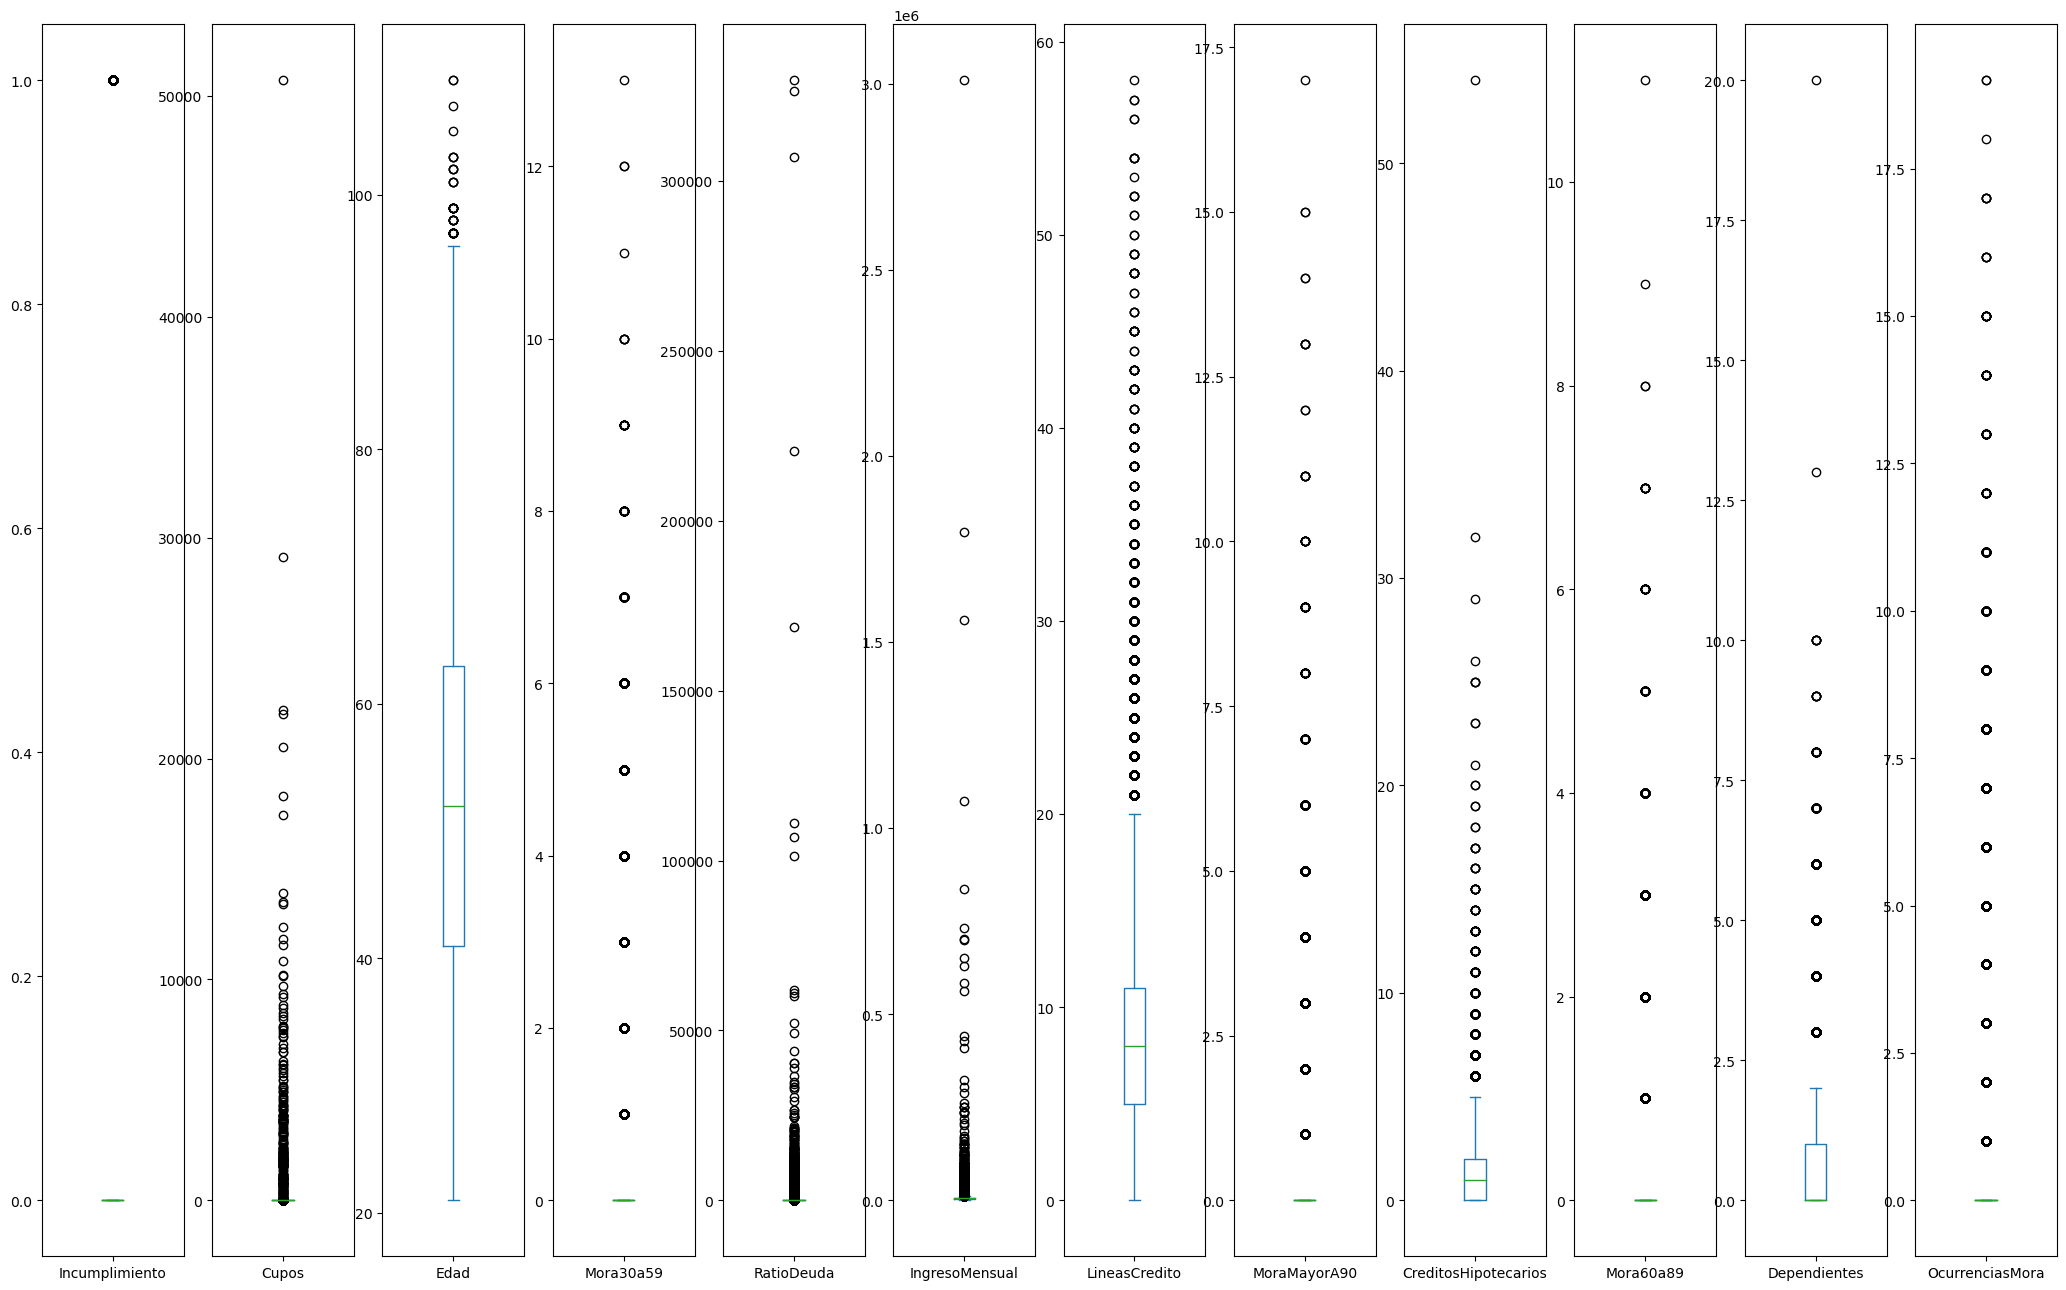

In [23]:
d.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))

Incumplimiento             Axes(0.125,0.11;0.0545775x0.77)
Cupos                   Axes(0.190493,0.11;0.0545775x0.77)
Edad                    Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59               Axes(0.321479,0.11;0.0545775x0.77)
RatioDeuda              Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual          Axes(0.452465,0.11;0.0545775x0.77)
LineasCredito           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90            Axes(0.583451,0.11;0.0545775x0.77)
CreditosHipotecarios    Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89               Axes(0.714437,0.11;0.0545775x0.77)
Dependientes             Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora         Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

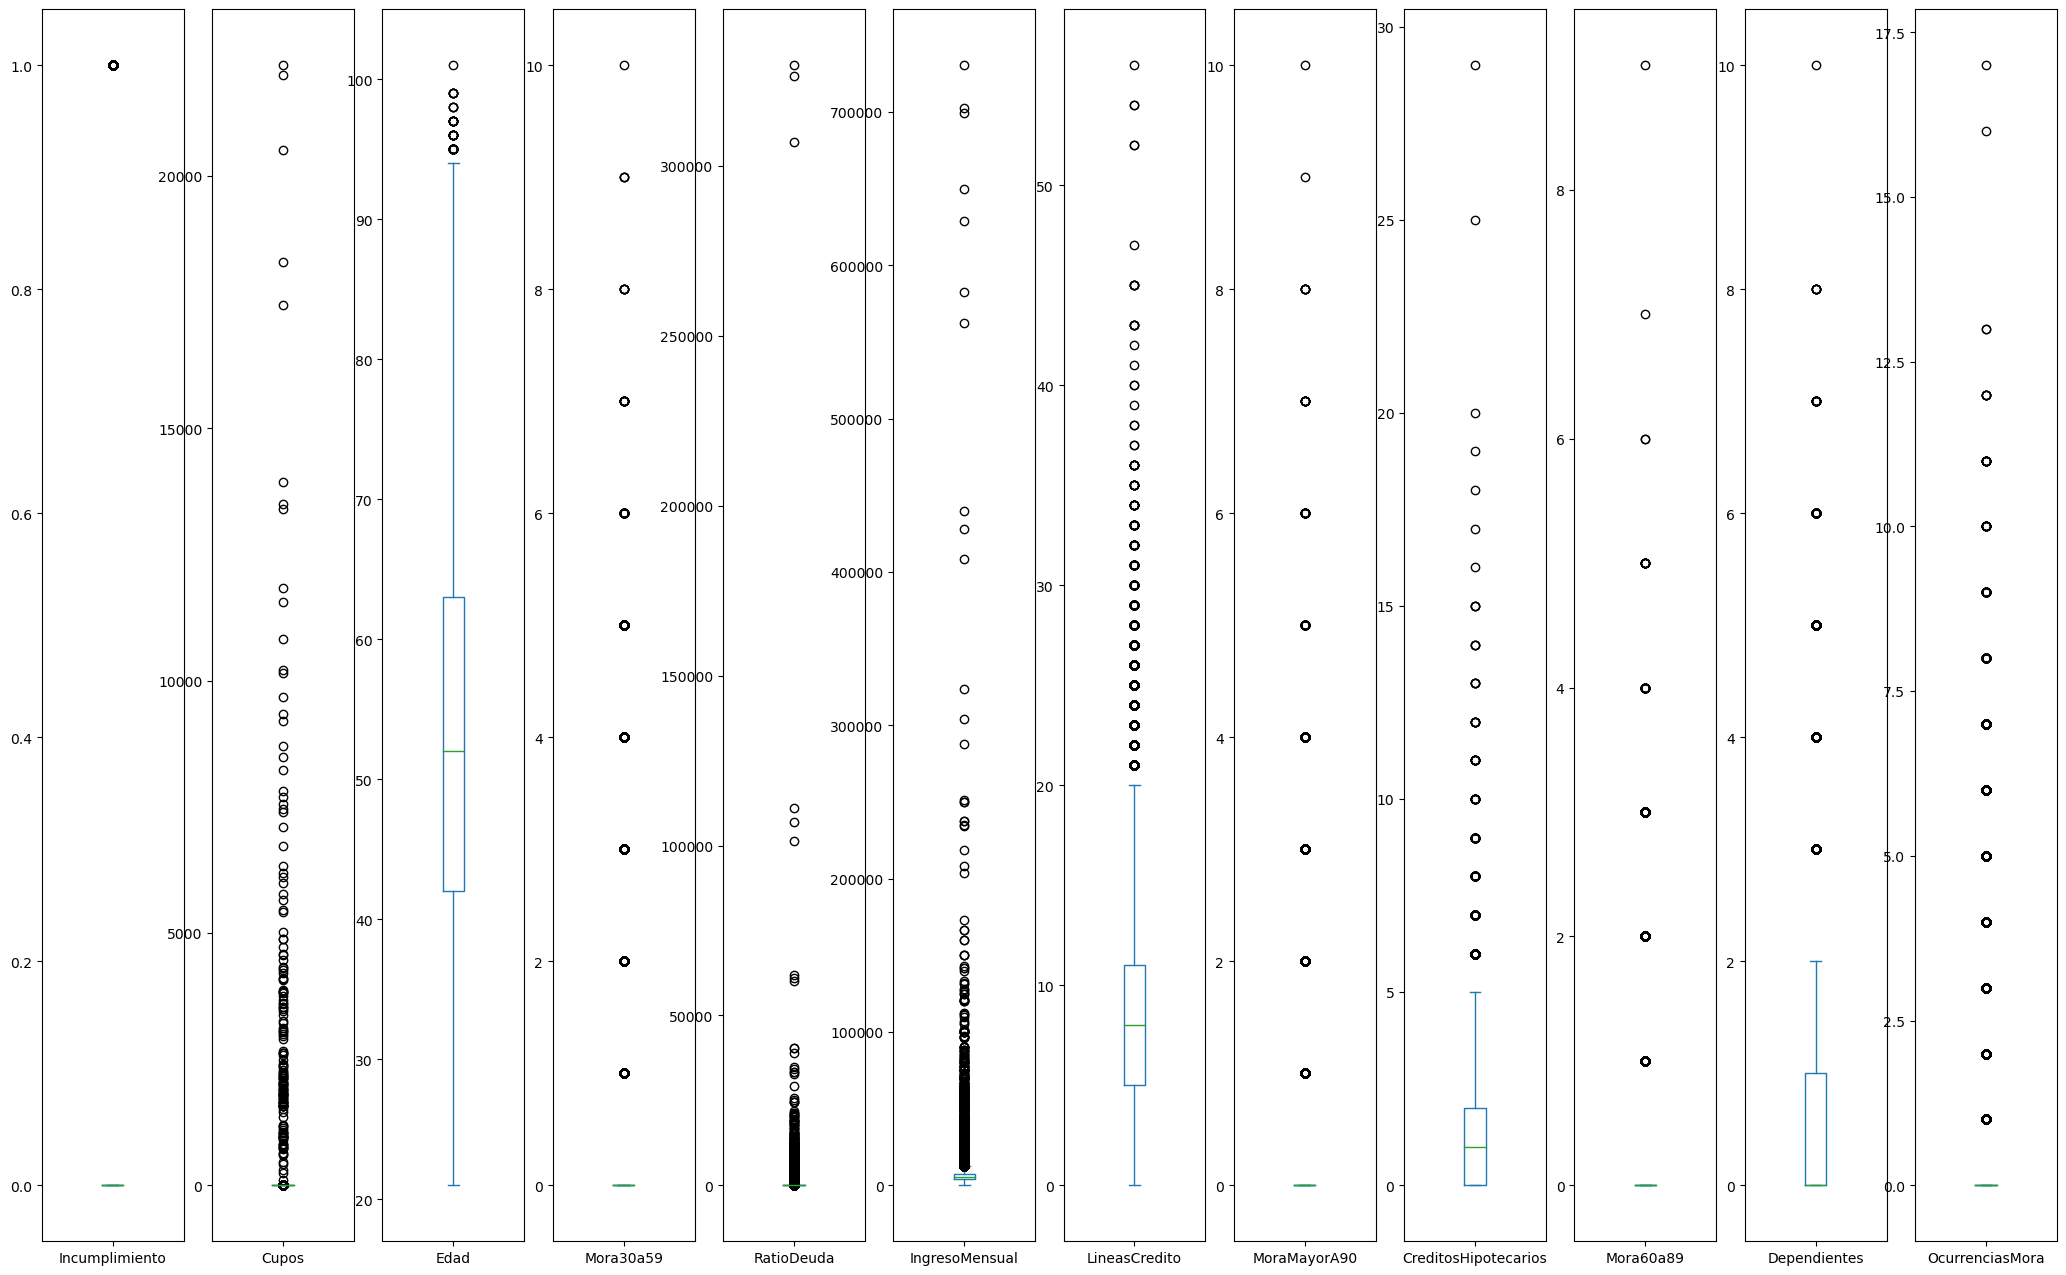

In [24]:
df.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))


In [25]:
df.describe()

,Incumplimiento,Cupos,Edad,Mora30a59,RatioDeuda,IngresoMensual,LineasCredito,MoraMayorA90,CreditosHipotecarios,Mora60a89,Dependientes,OcurrenciasMora
count,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000,134630.000000
mean,0.056845,5.039707,52.317388,0.207836,359.085948,6329.610221,8.334695,0.065104,1.001575,0.050152,0.721697,0.323093
std,0.231546,195.498849,14.516912,0.596269,1964.352269,7583.338502,4.828028,0.356584,1.042030,0.268135,1.075041,0.885274
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.028933,42.000000,0.000000,0.179084,3953.250000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.144985,52.000000,0.000000,0.368059,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.528447,63.000000,0.000000,0.885140,7333.000000,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,22198.000000,101.000000,10.000000,329664.000000,730483.000000,56.000000,10.000000,29.000000,9.000000,10.000000,17.000000


In [25]:
# Exportar df a csv
nombre_archivo = 'data/Preprocessed.csv'

df.to_csv(nombre_archivo, index=False)